<center><h1>Sentiment Analysis – Global Warming/Climate Change<h1/><center>

Contributors evaluated tweets for belief in the existence of global warming or climate change. The possible answers were:
* "Yes" if the tweet suggests global warming is occurring, 
* "No" if the tweet suggests global warming is not occurring

We also provide a confidence score for the classification of each tweet.

In [1]:
import pandas as pd
import numpy as np

data = pd.read_csv("tweet_global_warming.csv")

print(data.shape)

(4225, 3)


In [2]:
data.head()

,tweet,existence,existence.confidence
0,Global warming report urges governments to act...,Yes,1.0000
1,Fighting poverty and global warming in Africa ...,Yes,1.0000
2,Carbon offsets: How a Vatican forest failed to...,Yes,0.8786
3,Carbon offsets: How a Vatican forest failed to...,Yes,1.0000
4,URUGUAY: Tools Needed for Those Most Vulnerabl...,Yes,0.8087


In [3]:
data.existence.value_counts()

Yes    3111
No     1114
Name: existence, dtype: int64

## Basic Preprocessing (Noise Removal)

In [4]:
import re, string, unicodedata
from bs4 import BeautifulSoup

In [5]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    return text

data['tweet'] = data['tweet'].apply(denoise_text)

## Word Tokenization

In [6]:
from nltk import word_tokenize, sent_tokenize

In [7]:
tokens = data['tweet'].apply(word_tokenize)

In [8]:
tokens.head()

0    [Global, warming, report, urges, governments, ...
1    [Fighting, poverty, and, global, warming, in, ...
2    [Carbon, offsets, :, How, a, Vatican, forest, ...
3    [Carbon, offsets, :, How, a, Vatican, forest, ...
4    [URUGUAY, :, Tools, Needed, for, Those, Most, ...
Name: tweet, dtype: object

## Advanced Preprocessing

In [9]:
# !pip install contractions
# !pip install inflect
# !pip install autocorrect
# import contractions
import inflect
from autocorrect import spell
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer

In [10]:
def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

# def replace_contractions(words):
#     """Replace contractions in string of text"""
#     return contractions.fix(words)

def replace_numbers(words):
    """Replace all interger occurrences in list of tokenized words with textual representation"""
    p = inflect.engine()
    new_words = []
    for word in words:
        if word.isdigit():
            new_word = p.number_to_words(word)
            new_words.append(new_word)
        else:
            new_words.append(word)
    return new_words

def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stopwords.words('english'):
            new_words.append(word)
    return new_words

def spelling_correction(words):
    """Autocorrect the spelling of the words"""
    new_words = [spell(w) for w in (words)]
    return new_words

def stem_words(words):
    """Stem words in list of tokenized words"""
    stemmer = LancasterStemmer()
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
    return stems

def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

In [11]:
tokens = tokens.apply(remove_non_ascii)
tokens = tokens.apply(to_lowercase)
tokens = tokens.apply(remove_punctuation)
tokens = tokens.apply(replace_numbers)
tokens = tokens.apply(remove_stopwords)
# tokens = tokens.apply(spelling_correction) # Takes time
tokens = tokens.apply(stem_words)
tokens = tokens.apply(lemmatize_verbs)

Stemming and Lemmatization helps us to achieve the root forms (sometimes called synonyms in search context) of inflected (derived) words.

### Stemming
Stemming is the process of reducing inflection in words to their root forms such as mapping a group of words to the same stem even if the stem itself is not a valid word in the Language.

Stem (root) is the part of the word to which you add inflectional (changing/deriving) affixes such as (-ed,-ize, -s,-de,mis). So stemming a word or sentence may result in words that are not actual words. Stems are created by removing the suffixes or prefixes used with a word.

**For Example:** Stemming will map the words “cook,” “cooking,” and “cooked” all to the same stem of “cook.”

### Lemmatize
Lemmatization, unlike Stemming, reduces the inflected words properly ensuring that the root word belongs to the language. In Lemmatization root word is called Lemma. A lemma (plural lemmas or lemmata) is the canonical form, dictionary form, or citation form of a set of words.

**For example:** runs, running, ran are all forms of the word run, therefore run is the lemma of all these words. Because lemmatization returns an actual word of the language, it is used where it is necessary to get valid words.

## Data Partitioning

In [12]:
def tokens_to_sentence(words):
    return ' '.join(words)

In [13]:
X = tokens.apply(tokens_to_sentence)
y = data['existence'].replace({'Yes':1, 'No':0})

## Bag of Words
The following code uses the bag of words model to convert text documents into corresponding numerical features:

Count Vectorizer: The most straightforward one, it counts the number of times a token shows up in the document and uses this value as its weight.

In [14]:
import pickle
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(max_features=1500, 
                             min_df=5, 
                             max_df=0.7)

X = vectorizer.fit_transform(X).toarray() 

pickle.dump(vectorizer.vocabulary_,open("feature.pkl","wb"))

## Finding TF-IDF
The bag of words approach works fine for converting text to numbers. However, it has one drawback. It assigns a score to a word based on its occurrence in a particular document. It doesn't take into account the fact that the word might also be having a high frequency of occurrence in other documents as well. TFIDF resolves this issue by multiplying the term frequency of a word by the inverse document frequency. The TF stands for "Term Frequency" while IDF stands for "Inverse Document Frequency".

The term frequency is calculated as:

$$Term\;frequency = \frac{(Number\;of\;Occurrences\;of\;a\;word)}{(Total\;words\;in\;the\;document)}$$

And the Inverse Document Frequency is calculated as:

$$IDF(word) = Log[\frac{(Total\;number\;of\;documents)}{(Number\;of\;documents\;containing\;the\;word)}]$$

In [15]:
from sklearn.feature_extraction.text import TfidfTransformer  

tfidfconverter = TfidfTransformer()  

X = tfidfconverter.fit_transform(X).toarray()  

Also learn about **Word2Vec**.

## Constructing Training and Testing Sets

In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234, stratify=y)

In [17]:
print("""Training shape: {}
Testing shape: {}""".format(X_train.shape, X_test.shape))

Training shape: (3380, 1413)
Testing shape: (845, 1413)


## Modeling

In [18]:
from sklearn.naive_bayes import MultinomialNB

nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [19]:
from sklearn.metrics import accuracy_score

y_pred = nb_model.predict(X_test)

print(accuracy_score(y_test, y_pred))

0.8355029585798817


## Word Cloud Analysis

In [30]:
tokens = data['tweet'].apply(word_tokenize)
tokens = tokens.apply(remove_non_ascii)
tokens = tokens.apply(to_lowercase)
tokens = tokens.apply(remove_punctuation)
tokens = tokens.apply(replace_numbers)
tokens = tokens.apply(remove_stopwords)

In [31]:
wc_data = tokens.apply(tokens_to_sentence).loc[y==1] # Use 1 for Yes, 0 for No
token_data = wc_data.str.cat(sep=' ')
token_data = word_tokenize(token_data)
vocabulary = set(token_data)
print(len(vocabulary))

7966


In [32]:
from nltk import FreqDist

frequency_dist = FreqDist(token_data)
sorted(frequency_dist,key=frequency_dist.__getitem__, reverse=True)[0:10]

['http',
 'climate',
 'change',
 'global',
 'warming',
 'rt',
 'via',
 'new',
 'us',
 'news']

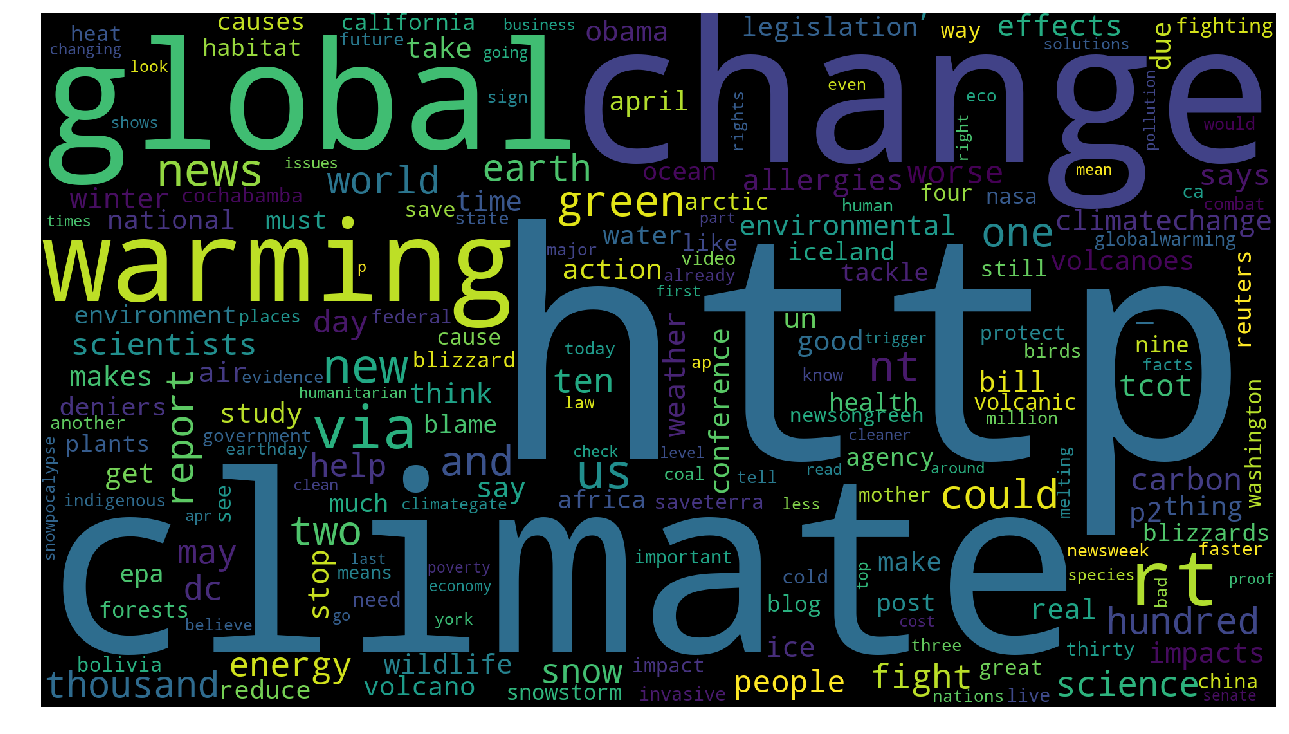

In [33]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set();

from wordcloud import WordCloud

wordcloud = WordCloud(width=1920, #1920 x 1080 
                      height=1080,
                      stopwords=stopwords.words('english')).generate_from_frequencies(frequency_dist)

fig, ax = plt.subplots(figsize=(20,10))
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show();

fig.savefig('word_cloud.jpg', dpi=100)